# Notes for PriceMe (DAS 2019)

In [1]:
import pandas as pd
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data19 = pd.read_csv("survey_results_public19.csv")
data19.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [3]:
data19['CompTotal'].size, data19['CompTotal'].isna().sum()

(88883, 32938)

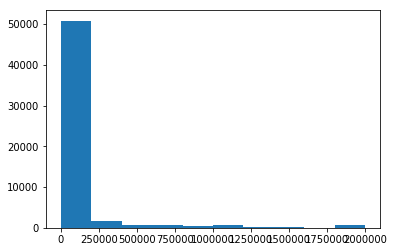

In [4]:
plt.hist(data19['ConvertedComp'].dropna())
plt.show()

# Model

In [5]:
import math
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae


### Steps
- drop NaNs
- choose input columns (numerical + categorical(OneHotEncode))
- apply basic cuts
- define Pipeline = encode + fit model
- GridSearchCV on chosen parameters
- use LinearRegressor/RandomForestRegressor/XGBRegressor

## Prepare training set (selected columns + cuts + train split)

In [6]:
data = data19.dropna(subset=['Age', 'EdLevel', 'MainBranch','Student','ConvertedComp', 'Employment'])
col_num = ['Age']
cat_feature_cols = ['Student', 'EdLevel', 'MainBranch', 'Employment'] #choose input data

column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), cat_feature_cols)], remainder='passthrough')

df_tar = data['ConvertedComp'][data['ConvertedComp']<500000] #upper cut
df_tar = df_tar[data['ConvertedComp']>3000] #bottom cut
df_features_all = data[col_num + cat_feature_cols][data['ConvertedComp']<500000] #upper cut
df_features_all = df_features_all[data['ConvertedComp']>3000] #bottom cut

X_train, X_test, y_train, y_test = train_test_split(df_features_all, df_tar, test_size=0.25, random_state=666)

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Prepare pipeline and GridSearch

In [7]:
#model = XGBRegressor()
model =  RandomForestRegressor()
param_grid = {'reg__max_depth': np.arange(10,25,5)}#, 'reg__n_estimators': np.arange(100,110,10)} #optimise max_depth for now

pipeline_steps = [('col_trans', column_transformer), ('reg',model)] #encode and fit XGB
pipe0 = Pipeline(pipeline_steps)

model_full0 = GridSearchCV(estimator=pipe0, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', iid=False).fit(X_train, y_train)
model_final =  model_full0.best_estimator_ #best model

print("Trained on {0} training samples".format(y_train.size))
print("Best params ...",model_full0.best_params_)

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

Trained on 36267 training samples
Best params ... {'reg__max_depth': 10}


### Evaluate
- true vs. predicted plot
- MSE, MAE
- compare prob. distributions

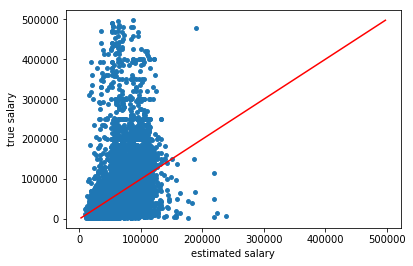

RMSE =  59710.487624120535
MAE  =  39247.17556405717


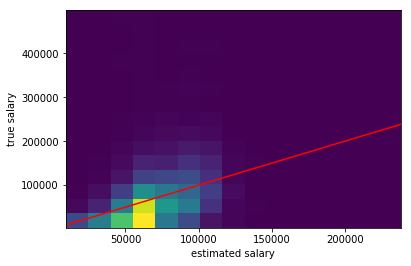

RMSE =  59710.487624120535
MAE  =  39247.17556405717


In [8]:
plt.scatter(model_final.predict(X_test),y_test,15)
x = np.arange(min(y_test),max(y_test))
plt.plot(x, x, color = 'red')
plt.xlabel("estimated salary")
plt.ylabel("true salary")
plt.show()
print("RMSE = ",math.sqrt(mse(model_final.predict(X_test),y_test)))
print("MAE  = ",mae(model_final.predict(X_test),y_test))

plt.hist2d(model_final.predict(X_test),y_test,15)
x = np.arange(min(y_test),max(y_test))
plt.plot(x, x, color = 'red')
plt.xlabel("estimated salary")
plt.ylabel("true salary")
plt.show()
print("RMSE = ",math.sqrt(mse(model_final.predict(X_test),y_test)))
print("MAE  = ",mae(model_final.predict(X_test),y_test))

## Train Data

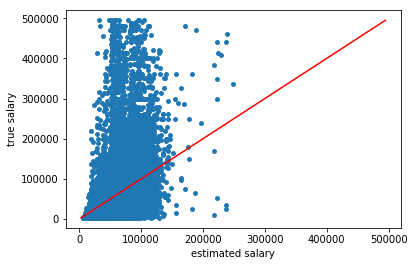

RMSE =  58568.73544619891
MAE  =  38349.50177235543


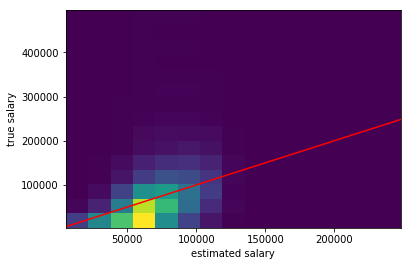

RMSE =  58568.73544619891
MAE  =  38349.50177235543


In [9]:
plt.scatter(model_final.predict(X_train),y_train,15)

x = np.arange(min(y_train),max(y_train))
plt.plot(x, x, color = 'red')
plt.xlabel("estimated salary")
plt.ylabel("true salary")
plt.show()
print("RMSE = ",math.sqrt(mse(model_final.predict(X_train),y_train)))
print("MAE  = ",mae(model_final.predict(X_train),y_train))



plt.hist2d(model_final.predict(X_train),y_train,15)

x = np.arange(min(y_train),max(y_train))
plt.plot(x, x, color = 'red')
plt.xlabel("estimated salary")
plt.ylabel("true salary")
plt.show()
print("RMSE = ",math.sqrt(mse(model_final.predict(X_train),y_train)))
print("MAE  = ",mae(model_final.predict(X_train),y_train))

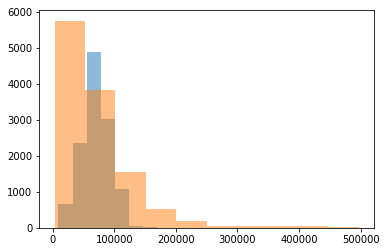

In [10]:
plt.hist(model_final.predict(X_test),alpha = 0.5)
plt.hist(y_test,alpha = 0.5)
plt.show()

### Observations
- use the cuts for salary
- lots of unique countries --> cuts (?)
- prog. languages need some decoding